# Setup

In [1]:
import copy
import numpy as np
import pandas as pd
import anndata as an
import scanpy as sc
import os

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [2]:
# Make sure you run Jupyter Notebook from project root
%cd ..
filename = "GSE72857_accession_formatted.csv"
results_file = 'write/pbmc3k.h5ad'

C:\Users\jwald\Desktop\CS-7641-Project


In [3]:
adata = sc.read_csv(filename, first_column_names=True).T
adata

AnnData object with n_obs × n_vars = 10368 × 27297

# Preprocessing

In [4]:
count_depth = np.sum(adata.X, axis = 1)
print("count depth shape:{}".format(count_depth.shape))
#print(count_depth)
number_of_genes = np.sum(adata.X>0,axis=1)
print("number_of_genes shape:{}".format(number_of_genes.shape))
#print(number_of_genes)

count depth shape:(10368,)
number_of_genes shape:(10368,)


Text(0, 0.5, 'unique genes')

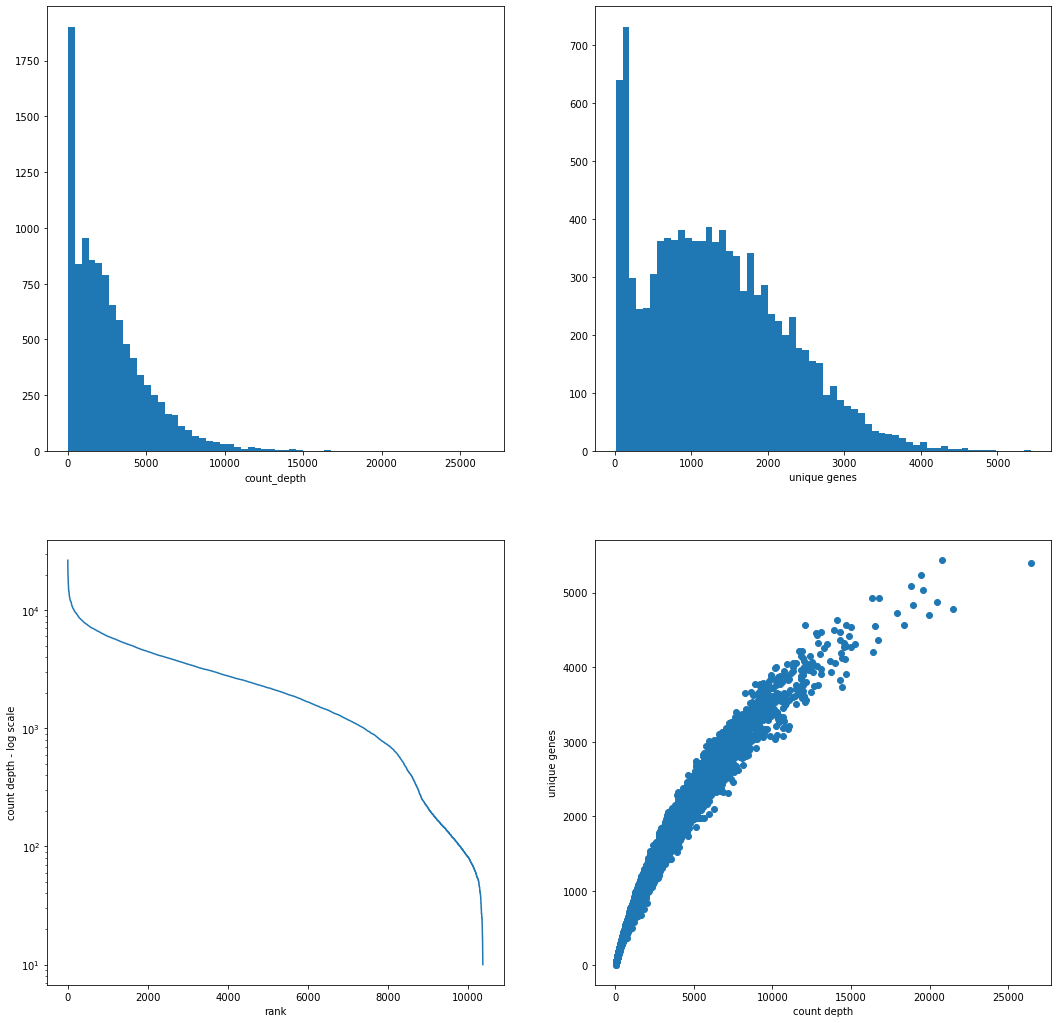

In [5]:
plt.rcParams["figure.figsize"] = [18,18]
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(count_depth,bins=60)
#axs[0,0].set_yscale("log")
axs[0,0].set_xlabel("count_depth")

axs[0,1].hist(number_of_genes,bins=60)
#axs[0,1].set_yscale("log")
axs[0,1].set_xlabel("unique genes")

axs[1,0].plot(range(len(count_depth)),sorted(count_depth,reverse=True))
axs[1,0].set_yscale("log")
axs[1,0].set_xlabel("rank")
axs[1,0].set_ylabel("count depth - log scale")

axs[1,1].scatter(count_depth,number_of_genes)
axs[1,1].set_xlabel("count depth")
axs[1,1].set_ylabel("unique genes")

(array([ 40.,  72., 182., 223., 218., 194., 176., 144., 119.,  94.,  73.,
         63.,  32.,  60.,  59.,  50.,  57.,  52.,  62.,  45.,  56.,  56.,
         52.,  54.,  74.,  61.,  72.,  93.,  87.,  76.,  73.,  81.,  91.,
         77.,  69.,  88.,  77.,  76.,  82.,  78.,  85.,  91.,  95.,  65.,
         91.,  86.,  81.,  77.,  77.,  82.,  83.,  81.,  88.,  68.,  78.,
         88.,  74.,  81.,  77.,  96.,  79.,  94.,  72.,  83.,  91.,  78.,
         69.,  81.,  85.,  92.,  69.,  85.,  84.,  73.,  84.,  80.,  69.,
         80.,  71.,  69.,  78.,  68.,  74.,  60.,  59.,  52.,  77.,  87.,
         76.,  82.,  57.,  58.,  63.,  58.,  48.,  56.,  62.,  59.,  68.,
         68.,  42.,  52.,  52.,  54.,  58.,  43.,  61.,  48.,  45.,  48.,
         48.,  45.,  38.,  45.,  53.,  57.,  53.,  41.,  36.,  37.,  43.,
         42.,  39.,  34.,  39.]),
 array([  10.  ,   29.92,   49.84,   69.76,   89.68,  109.6 ,  129.52,
         149.44,  169.36,  189.28,  209.2 ,  229.12,  249.04,  268.96,
         2

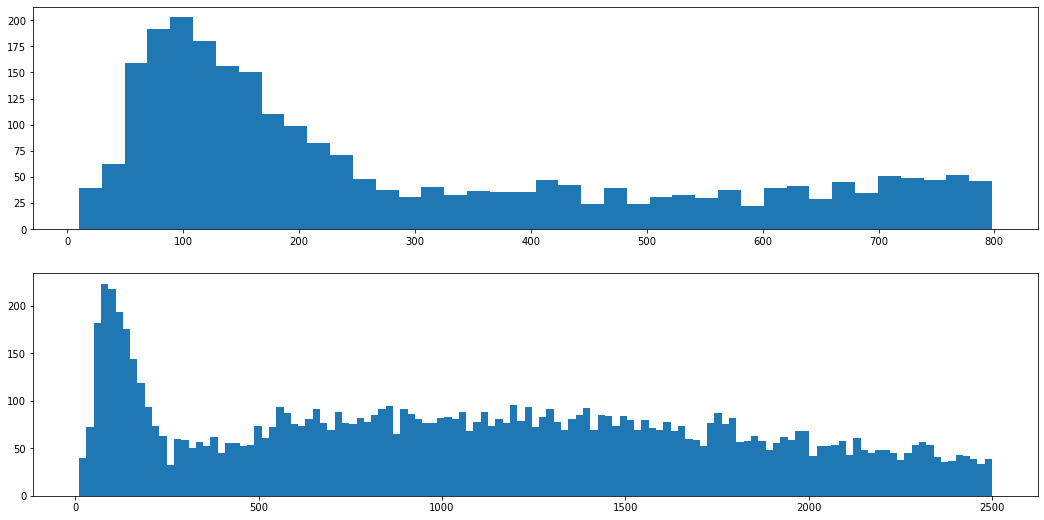

In [6]:
plt.rcParams["figure.figsize"] = [18,9]
fig2, axs2 = plt.subplots(2, 1)

mindepth = 1
maxdepth = 800
mingenes = 1
maxgenes = 2500

#axs2[0].hist(count_depth[np.where((count_depth <= maxdepth) & (count_depth >= mindepth))], bins=min([200,int(maxdepth/20)]),cumulative=True)
axs2[0].hist(count_depth[np.where((count_depth <= maxdepth) & (count_depth >= mindepth))], bins=min([200,int(maxdepth/20)]),cumulative=False)
#axs2[0].set_yscale("log")
#axs2[0].hist(count_depth[np.where((count_depth < maxdepth))], bins=21)

axs2[1].hist(number_of_genes[np.where((number_of_genes<=maxgenes) & (number_of_genes >= mingenes))],bins=min([200,int(maxgenes/20)]),cumulative=False)
#axs2[1].set_yscale("log")
#axs2[1].hist(number_of_genes[np.where((number_of_genes<maxgenes) )],bins=21)

I'll have to check how this dataset was collected, but it looks like these cells may already have been FACS sorted against some kind of live/dead stain prior to scRNA-seq, they are clean and missing populations with features characteristic of lysed cells


In [7]:
adata_filtered = copy.deepcopy(adata)
print(adata_filtered.X.shape)

sc.pp.filter_genes(adata_filtered, min_counts = 1)
print(adata_filtered.X.shape)

sc.pp.filter_cells(adata_filtered, min_counts = 300)
print(adata_filtered.X.shape)

sc.pp.filter_cells(adata_filtered, min_genes = 500)
print(adata_filtered.X.shape)

(10368, 27297)
(10368, 16162)
(8758, 16162)
(8100, 16162)


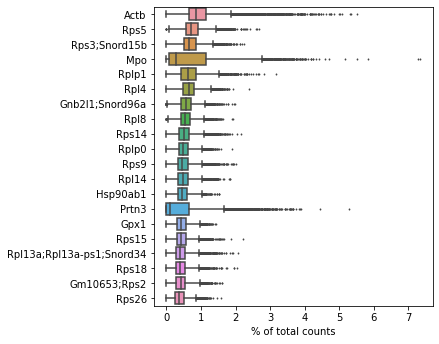

In [8]:
sc.pl.highest_expr_genes(adata_filtered, n_top=20, )

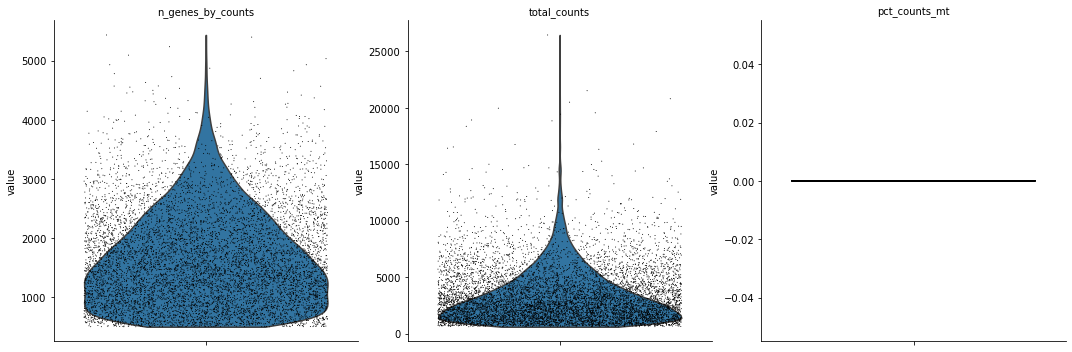

In [9]:
adata_filtered.var['mt'] = adata_filtered.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_filtered, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

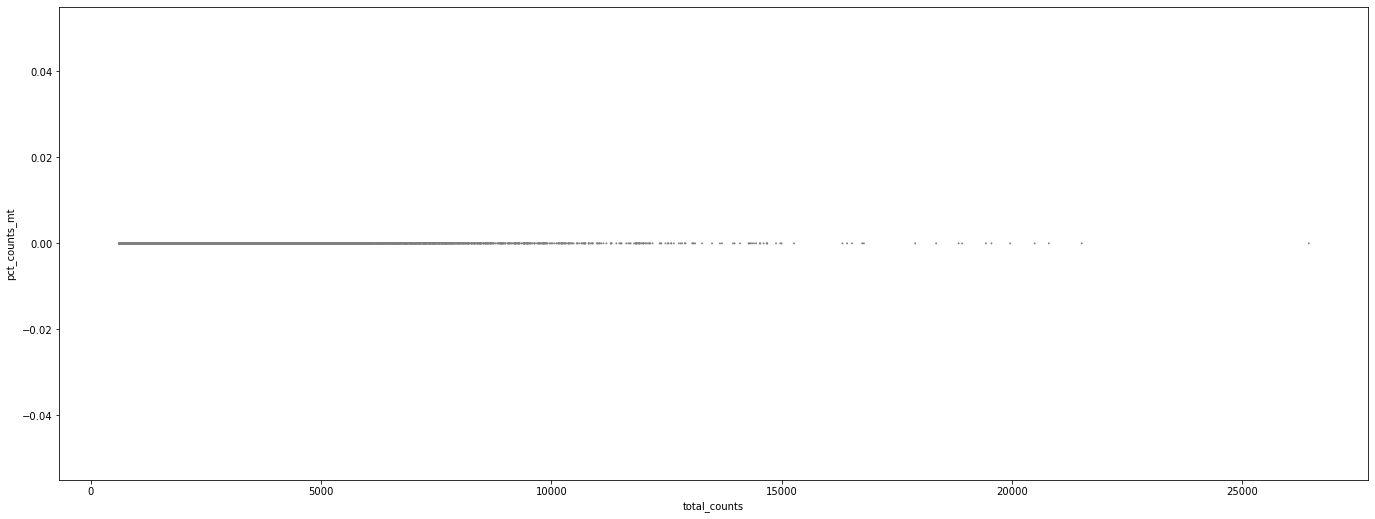

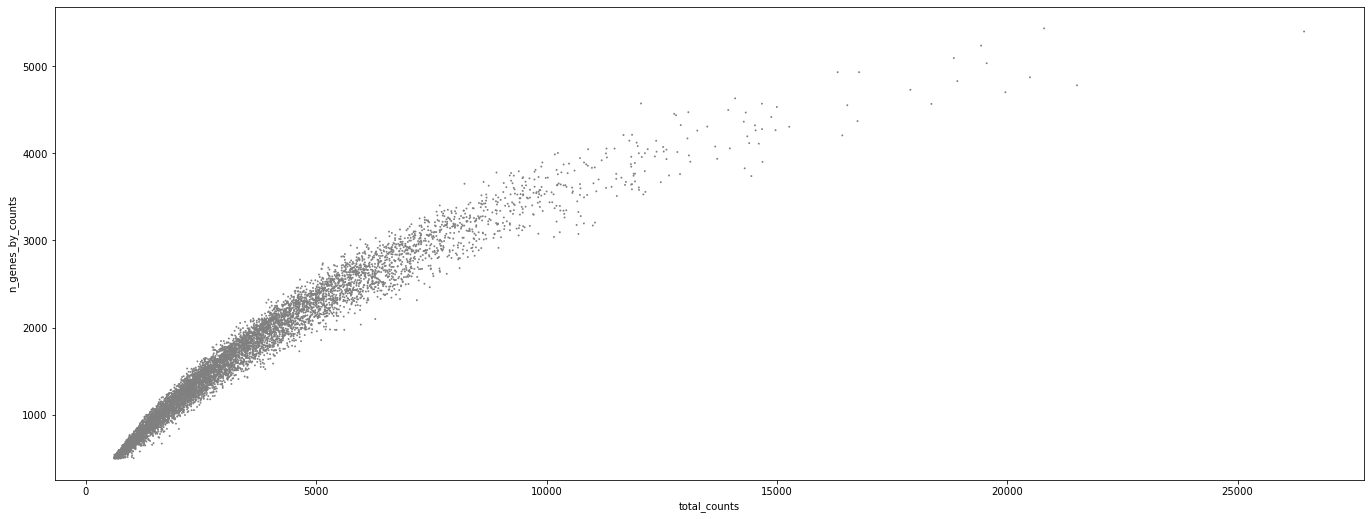

In [10]:
sc.pl.scatter(adata_filtered, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_filtered, x='total_counts', y='n_genes_by_counts')

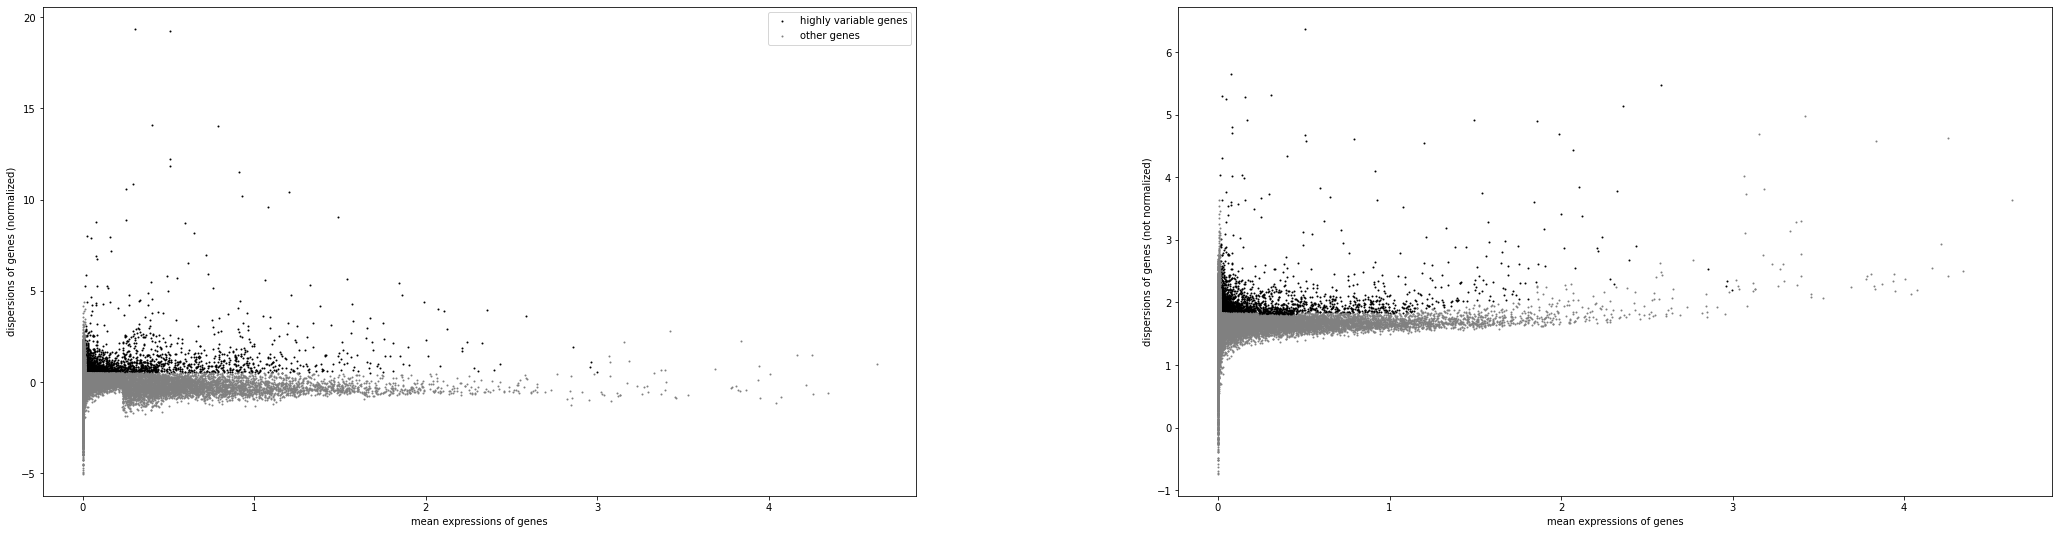

In [11]:
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
sc.pp.log1p(adata_filtered)
sc.pp.highly_variable_genes(adata_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_filtered)
adata_filtered.raw = adata_filtered

In [12]:
sc.pp.regress_out(adata_filtered, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_filtered, max_value=10)

# PCA

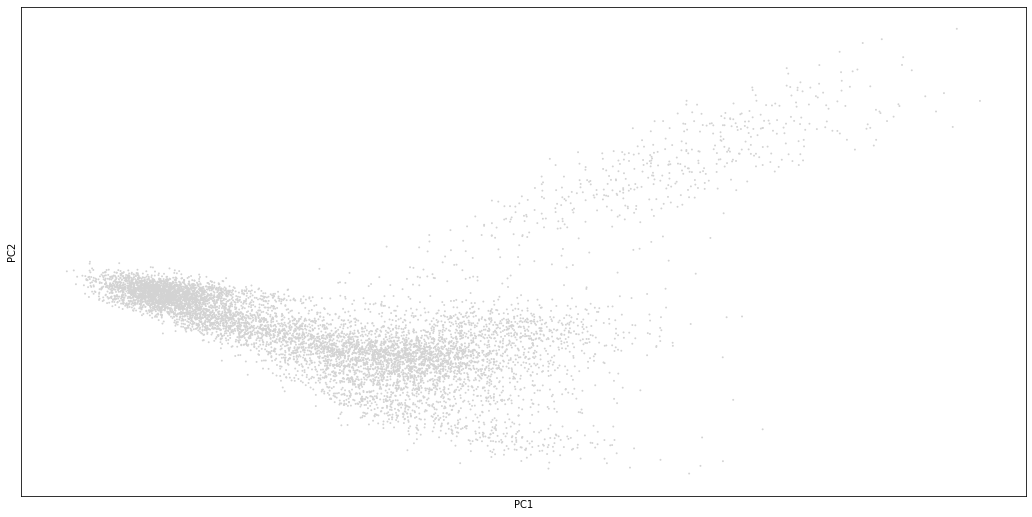

In [13]:
sc.tl.pca(adata_filtered, svd_solver='arpack')
sc.pl.pca(adata_filtered) #, color='CST3')

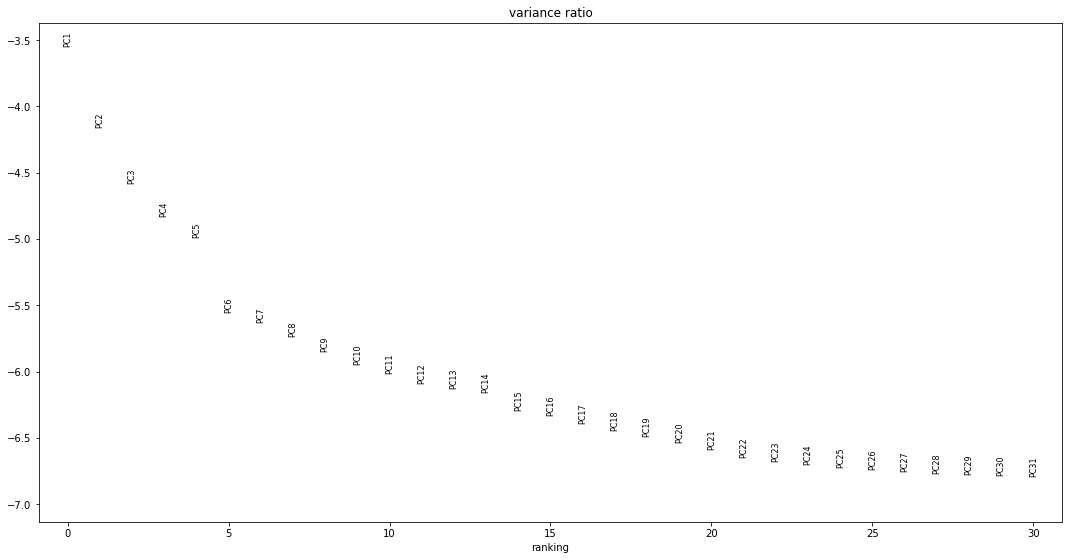

In [14]:
sc.pl.pca_variance_ratio(adata_filtered, log=True)

In [16]:
adata_filtered.write(results_file)
adata_filtered

AnnData object with n_obs × n_vars = 8100 × 16162
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Computing Neighborhood Graph

In [17]:
sc.pp.neighbors(adata_filtered, n_neighbors=10, n_pcs=40)

# Embedding Neighborhood Graph

In [18]:
sc.tl.louvain(adata_filtered)

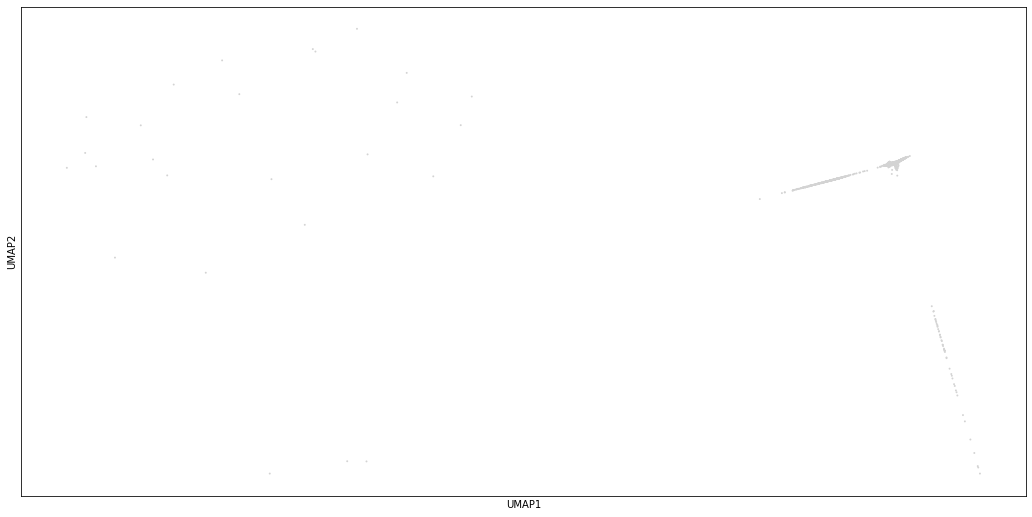

In [19]:
sc.tl.paga(adata_filtered)
sc.pl.paga(adata_filtered, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_filtered, init_pos='paga')
sc.tl.umap(adata_filtered)
sc.pl.umap(adata_filtered) #, color=['CST3', 'NKG7', 'PPBP'])

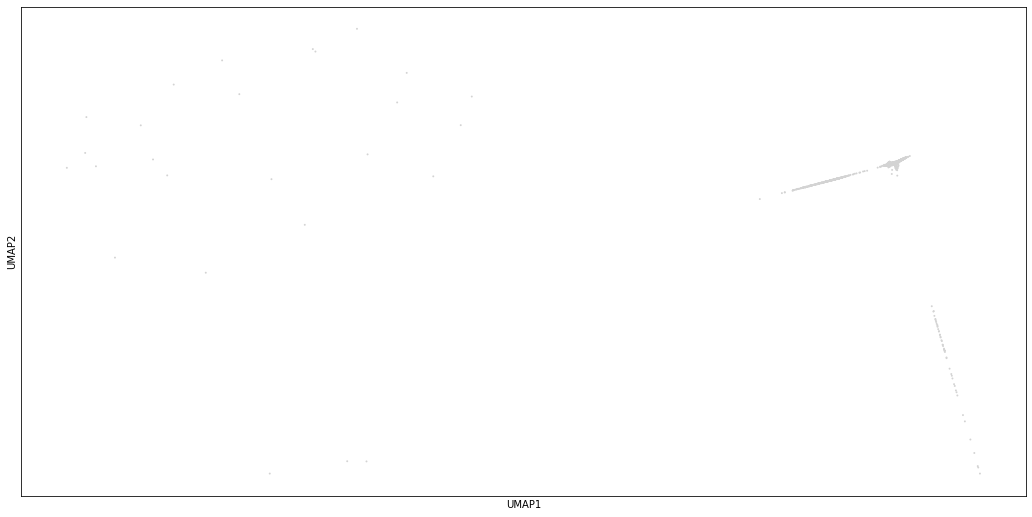

In [20]:
sc.pl.umap(adata_filtered, use_raw=False) #, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

# Clustering Neighborhood Graph

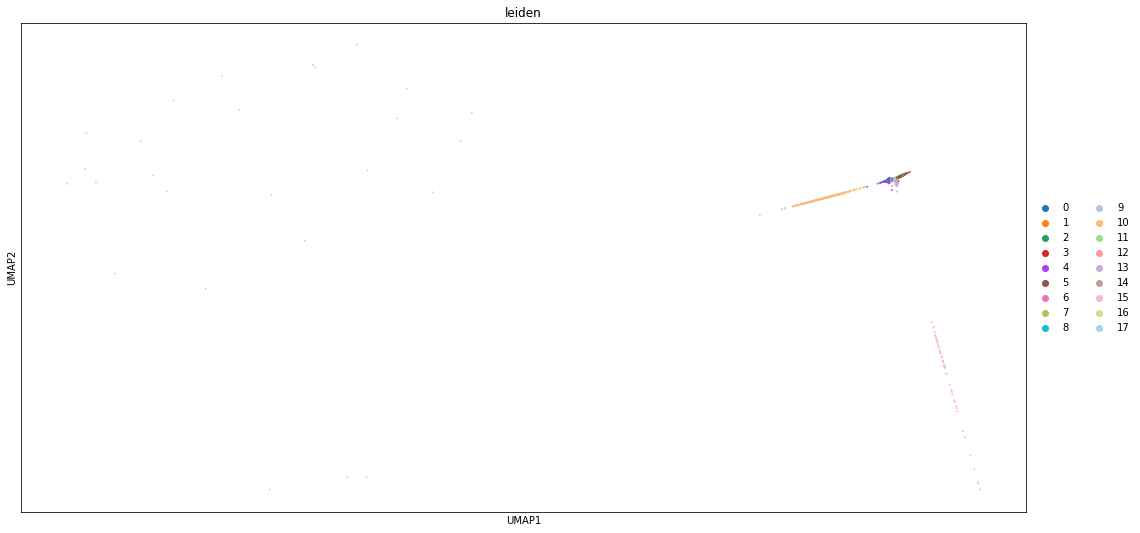

In [21]:
sc.tl.leiden(adata_filtered)
sc.pl.umap(adata_filtered, color=['leiden']) #, 'CST3', 'NKG7'])

In [22]:
adata_filtered.write(results_file)

# Finding Marker Genes

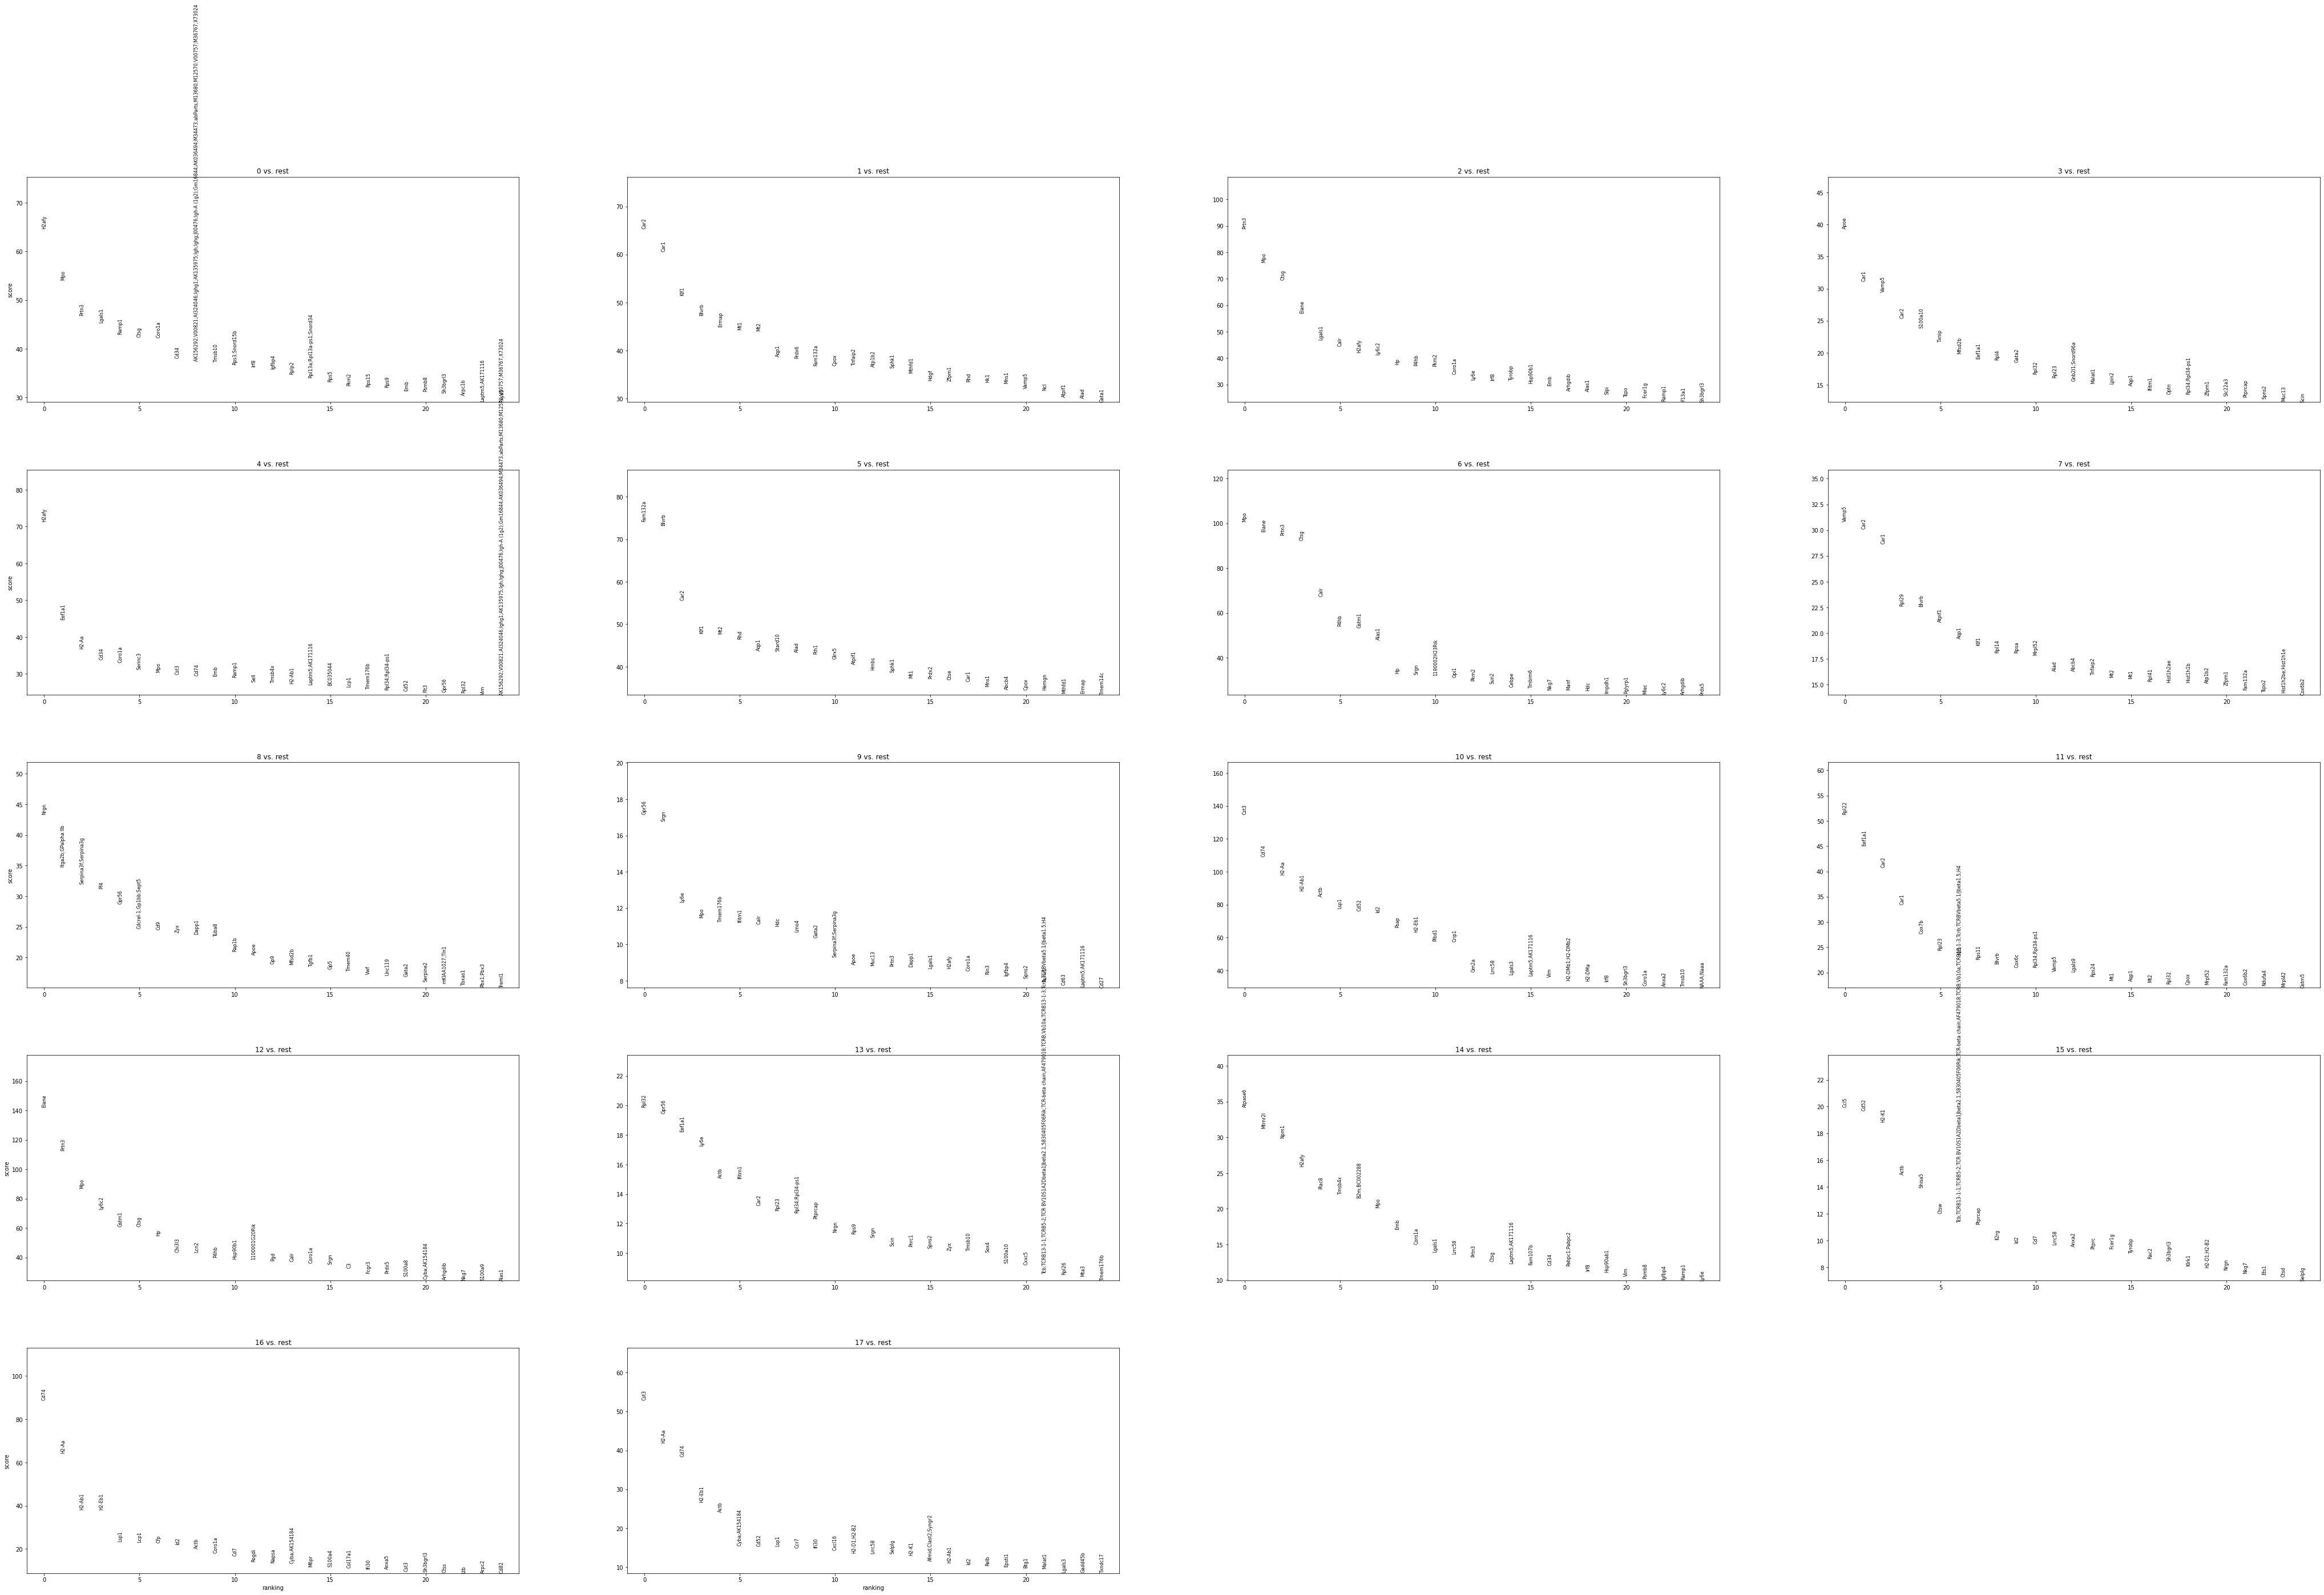

In [23]:
sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

ranking genes
    finished (0:00:22)


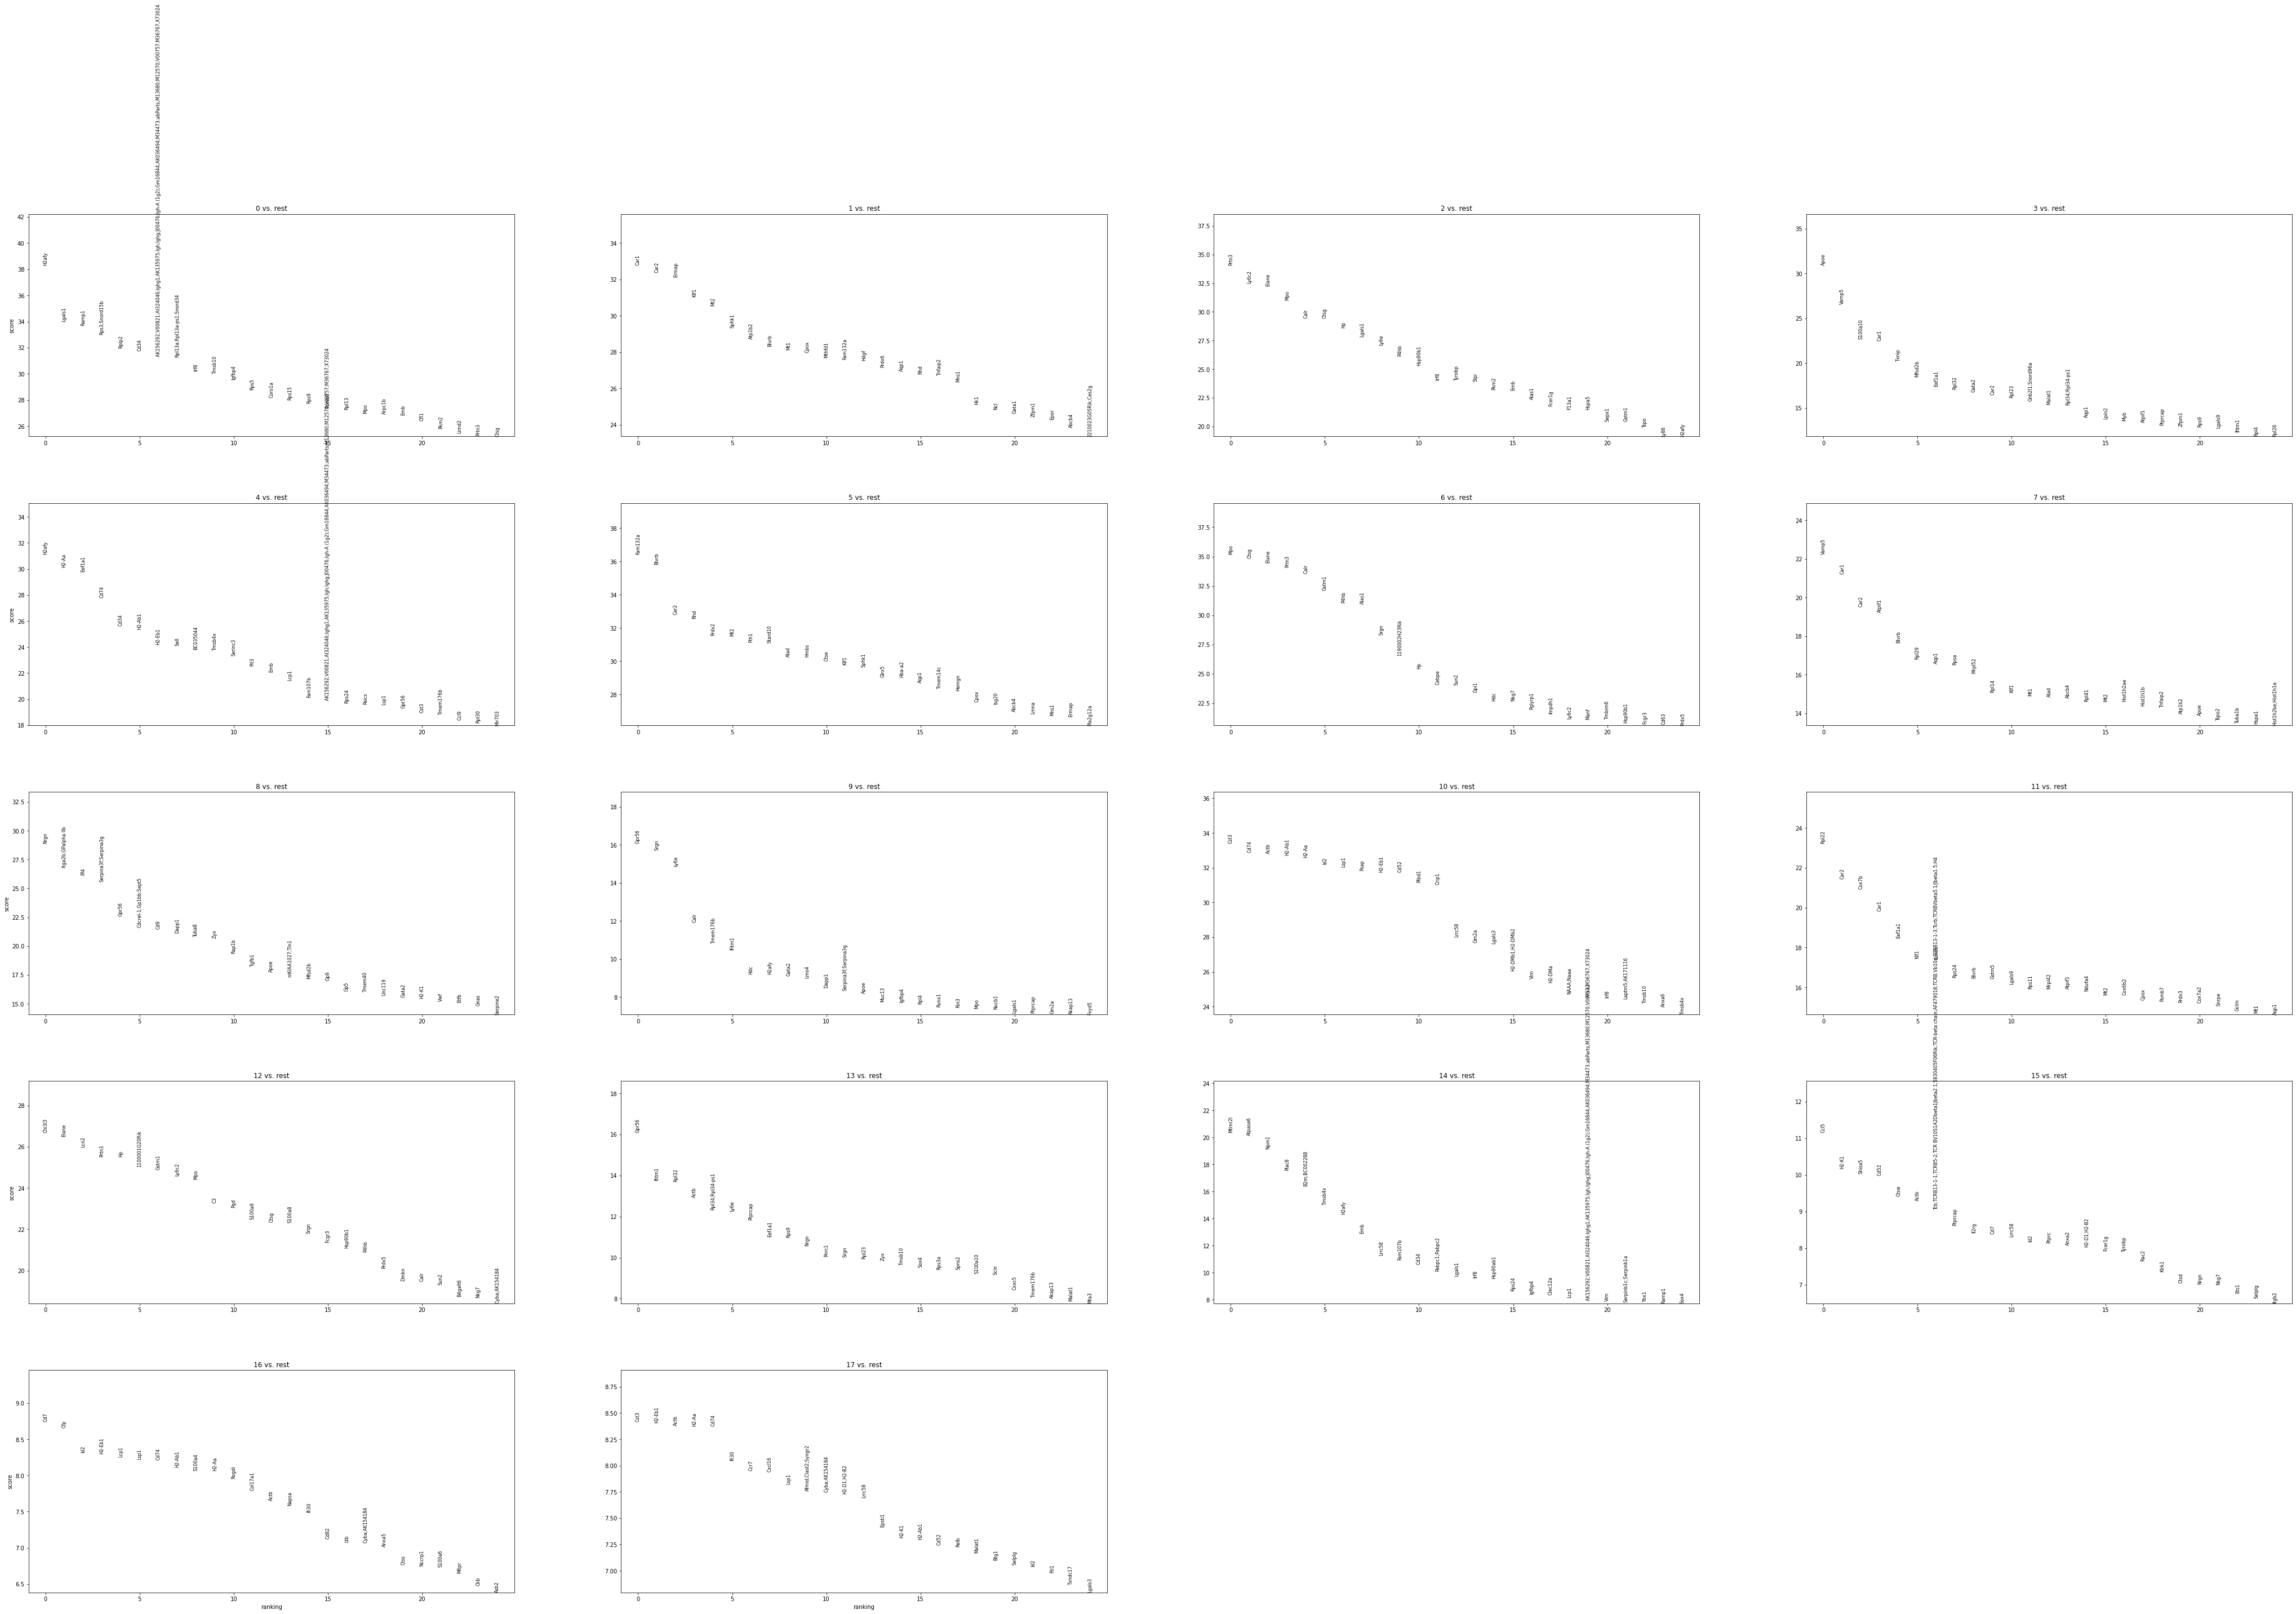

In [24]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

In [25]:
adata_filtered.write(results_file)

ranking genes
C:\Users\jwald\Anaconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
    finished (0:00:32)


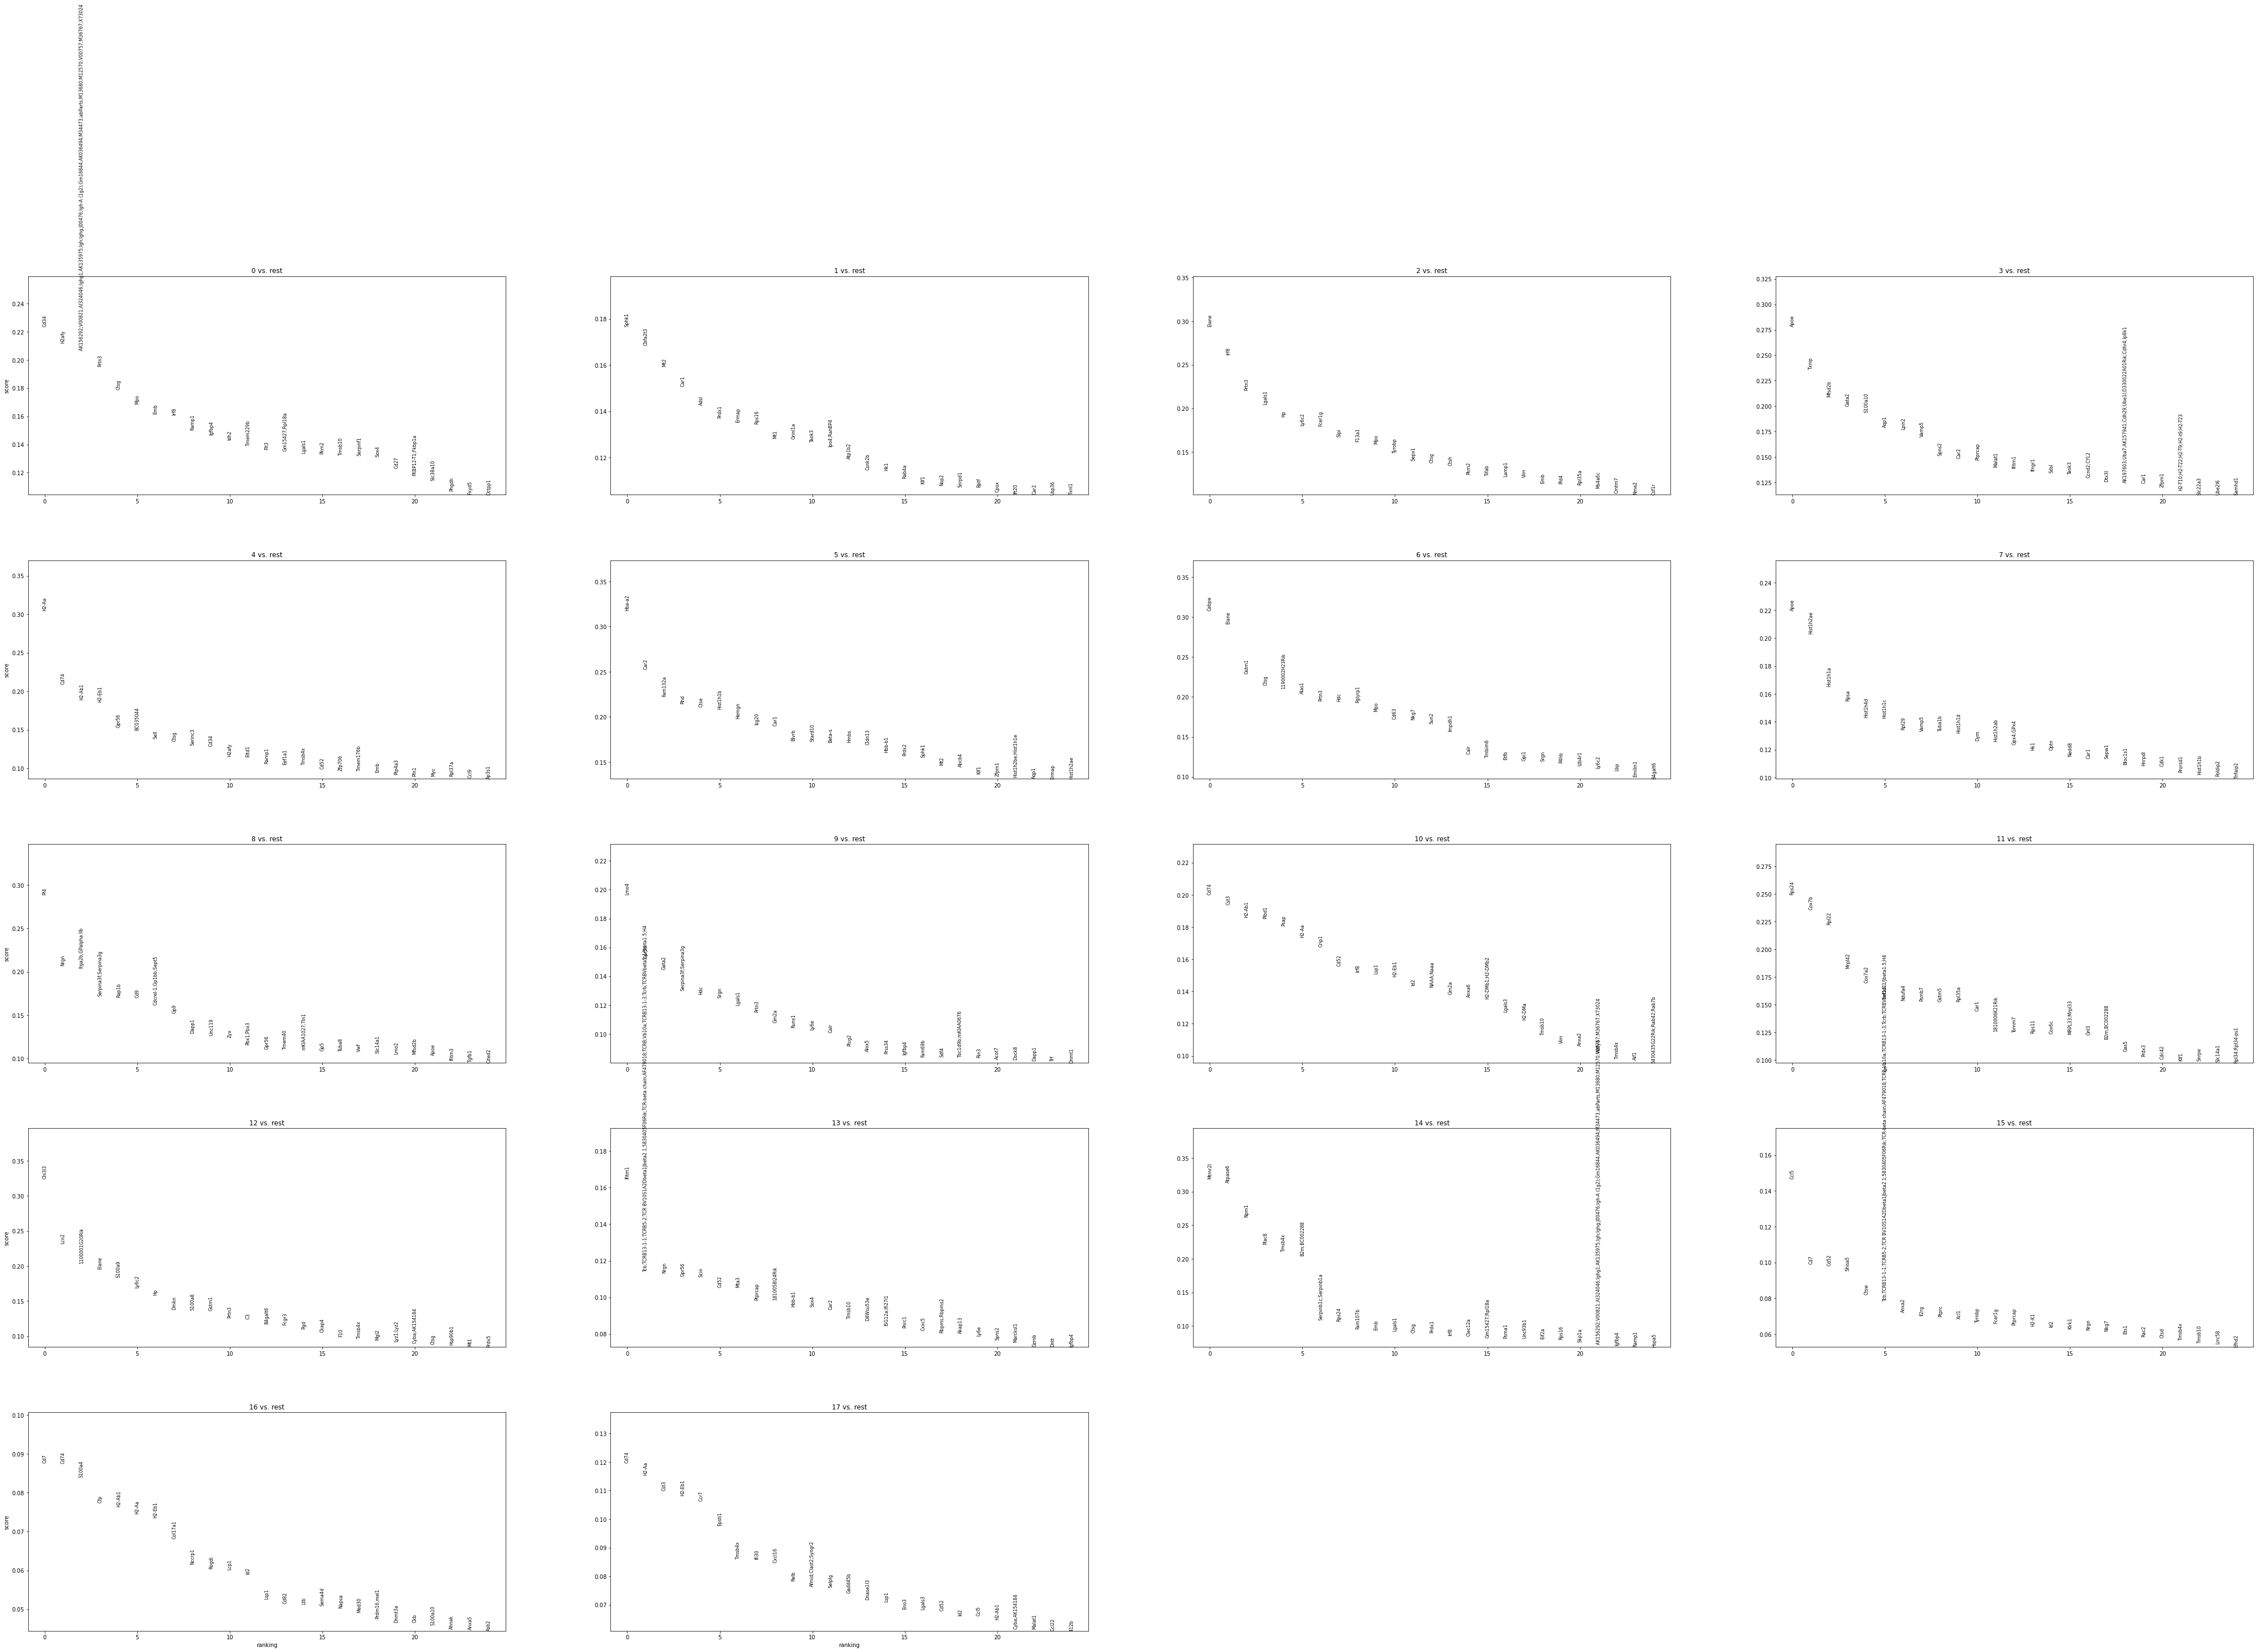

In [26]:
sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

In [27]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [28]:
adata = sc.read(results_file)

In [29]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,H2afy,Car1,Prtn3,Apoe,H2afy,Fam132a,Mpo,Vamp5,Nrgn,Gpr56,Cst3,Rpl22,Chi3l3,Gpr56,Mtrnr2l,Ccl5,Cd7,Cst3
1,Lgals1,Car2,Ly6c2,Vamp5,H2-Aa,Blvrb,Ctsg,Car1,Itga2b;GPalpha IIb,Srgn,Cd74,Car2,Elane,Ifitm1,Atpase6,H2-K1,Cfp,H2-Eb1
2,Ramp1,Ermap,Elane,S100a10,Eef1a1,Car2,Elane,Car2,Pf4,Ly6e,Actb,Cox7b,Lcn2,Rpl32,Npm1,Shisa5,Id2,Actb
3,Rps3;Snord15b,Klf1,Mpo,Car1,Cd74,Rhd,Prtn3,Atpif1,Serpina3f;Serpina3g,Calr,H2-Ab1,Car1,Prtn3,Actb,Plac8,Cd52,H2-Eb1,H2-Aa
4,Rplp2,Mt2,Calr,Txnip,Cd34,Prdx2,Calr,Blvrb,Gpr56,Tmem176b,H2-Aa,Eef1a1,Hp,Rpl34;Rpl34-ps1,B2m;BC002288,Ctsw,Lcp1,Cd74


In [30]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,13_n,13_p,14_n,14_p,15_n,15_p,16_n,16_p,17_n,17_p
0,H2afy,0.000000e+00,Car1,1.226027e-235,Prtn3,2.272880e-254,Apoe,7.845428e-210,H2afy,1.075476e-212,...,Gpr56,2.744571e-58,Mtrnr2l,3.145220e-92,Ccl5,6.346571e-29,Cd7,2.178513e-18,Cst3,3.752866e-17
1,Lgals1,2.201695e-253,Car2,4.137690e-230,Ly6c2,8.257990e-232,Vamp5,6.070498e-156,H2-Aa,1.551619e-199,...,Ifitm1,4.134923e-43,Atpase6,2.791462e-90,H2-K1,2.656120e-24,Cfp,4.649072e-18,H2-Eb1,4.172299e-17
2,Ramp1,2.778293e-249,Ermap,1.349806e-226,Elane,1.586793e-228,S100a10,6.078699e-114,Eef1a1,8.179533e-195,...,Rpl32,1.075967e-42,Npm1,9.996833e-82,Shisa5,1.016980e-23,Id2,9.185591e-17,Actb,5.260824e-17
3,Rps3;Snord15b,3.715129e-239,Klf1,1.821536e-211,Mpo,4.338189e-211,Car1,7.440794e-112,Cd74,6.515611e-170,...,Actb,2.535269e-38,Plac8,5.253257e-69,Cd52,1.659934e-23,H2-Eb1,1.015681e-16,H2-Aa,5.384772e-17
4,Rplp2,2.073571e-224,Mt2,4.546309e-205,Calr,8.342864e-191,Txnip,1.545043e-90,Cd34,6.451075e-145,...,Rpl34;Rpl34-ps1,6.110551e-35,B2m;BC002288,1.662700e-60,Ctsw,4.782102e-21,Lcp1,1.539268e-16,Cd74,5.451786e-17


ranking genes
    finished (0:00:03)


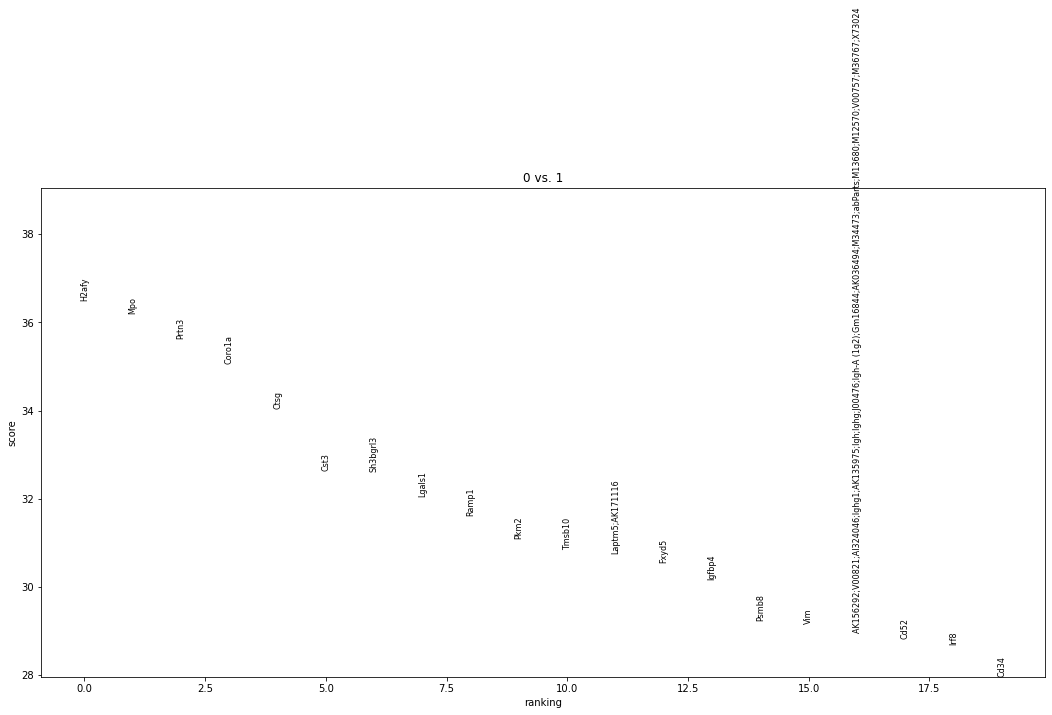

In [31]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [32]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Exception: Data must be 1-dimensional

In [ ]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');